In [1]:
import numpy as np
import matplotlib.pyplot as plt

from maze_dataset import MazeDataset, MazeDatasetConfig, LatticeMazeGenerators, SolvedMaze
from maze_dataset.tokenization import MazeTokenizer, TokenizationMode
from maze_dataset.plotting import plot_dataset_mazes
from maze_dataset.plotting.print_tokens import display_color_tokens_rgb, display_color_tokens_cmap, display_color_maze_tokens_AOTP
from maze_dataset.utils import corner_first_ndindex

Let's get a basic dataset first:

In [2]:
CFG: MazeDatasetConfig = MazeDatasetConfig(
	name="test",
	grid_n=5,
	n_mazes=5,
	maze_ctor=LatticeMazeGenerators.gen_dfs,
)

In [3]:
DATASET: MazeDataset = MazeDataset.from_config(CFG, local_base_path="../data/maze_dataset/")

(<Figure size 500x200 with 5 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

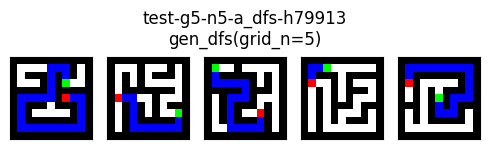

In [4]:
plot_dataset_mazes(DATASET)

Now, let's see how tokenization works:

In [5]:
TOKENIZER: MazeTokenizer = MazeTokenizer(tokenization_mode=TokenizationMode.AOTP_UT_rasterized, max_grid_size=100)

In [6]:
STRINGIFIED: list[str] = DATASET.as_tokens(TOKENIZER, join_tokens_individual_maze=True)
print("\n".join(STRINGIFIED))

<ADJLIST_START> (0,0) <--> (1,0) ; (2,0) <--> (3,0) ; (4,1) <--> (4,0) ; (2,0) <--> (2,1) ; (1,0) <--> (1,1) ; (3,4) <--> (2,4) ; (4,2) <--> (4,3) ; (0,0) <--> (0,1) ; (0,3) <--> (0,2) ; (4,4) <--> (3,4) ; (4,3) <--> (4,4) ; (4,1) <--> (4,2) ; (2,1) <--> (2,2) ; (1,4) <--> (0,4) ; (1,2) <--> (0,2) ; (2,4) <--> (2,3) ; (4,0) <--> (3,0) ; (2,2) <--> (3,2) ; (1,2) <--> (2,2) ; (1,3) <--> (0,3) ; (3,2) <--> (3,3) ; (0,2) <--> (0,1) ; (3,1) <--> (3,2) ; (1,3) <--> (1,4) ; <ADJLIST_END> <ORIGIN_START> (1,3) <ORIGIN_END> <TARGET_START> (2,3) <TARGET_END> <PATH_START> (1,3) (0,3) (0,2) (1,2) (2,2) (2,1) (2,0) (3,0) (4,0) (4,1) (4,2) (4,3) (4,4) (3,4) (2,4) (2,3) <PATH_END>
<ADJLIST_START> (2,1) <--> (2,2) ; (1,4) <--> (0,4) ; (2,4) <--> (1,4) ; (0,1) <--> (1,1) ; (1,0) <--> (2,0) ; (2,3) <--> (3,3) ; (3,3) <--> (3,4) ; (2,0) <--> (2,1) ; (1,3) <--> (1,2) ; (0,1) <--> (0,0) ; (1,3) <--> (1,4) ; (0,2) <--> (1,2) ; (4,0) <--> (3,0) ; (4,1) <--> (4,2) ; (3,1) <--> (2,1) ; (4,1) <--> (3,1) ; (2,3) 

In [7]:
from maze_dataset.plotting.print_tokens import color_maze_tokens_AOTP


x = STRINGIFIED[0].split()
display_color_tokens_rgb(x, np.random.randint(0, 255, (len(x),3)))
display_color_tokens_cmap(x, np.random.randint(0, 255, len(x)))
display_color_maze_tokens_AOTP(x)

now let's see how we can take the actual tokenized data to a `SolvedMaze`.

In [8]:
maze_toks: list[str] = """<ADJLIST_START> (1,1) <--> (2,1) ; (2,0) <--> (1,0) ; (0,1) <--> (0,0) ; (2,2) <--> (2,1) ; (2,0) <--> (2,1) ; (0,2) <--> (1,2) ; (0,0) <--> (1,0) ; (0,2) <--> (0,1) ; <ADJLIST_END> <ORIGIN_START> (0,0) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START> (0,0) (1,0) (2,0) (2,1) <PATH_END>""".split()
maze_encoded: list[int] = TOKENIZER.encode(maze_toks)
maze_tok_roundtrip: list[str] = TOKENIZER.decode(maze_encoded)
assert maze_toks == maze_tok_roundtrip

maze_from_toks: SolvedMaze = SolvedMaze.from_tokens(maze_toks, TOKENIZER)

print(maze_from_toks.as_ascii())
print(" ".join(maze_from_toks.as_tokens(TOKENIZER)))


#######
#S    #
#X### #
#X# # #
#X# ###
#XXE  #
#######
<ADJLIST_START> (0,0) <--> (0,1) ; (2,1) <--> (2,2) ; (1,1) <--> (2,1) ; (1,0) <--> (0,0) ; (2,1) <--> (2,0) ; (0,2) <--> (0,1) ; (2,0) <--> (1,0) ; (1,2) <--> (0,2) ; <ADJLIST_END> <ORIGIN_START> (0,0) <ORIGIN_END> <TARGET_START> (2,1) <TARGET_END> <PATH_START> (0,0) (1,0) (2,0) (2,1) <PATH_END>


# Vocab index

special tokens come first, but then there are a few choices for the rest of the tokens:

- `TokenizationMode.AOTP_UT_rasterized`: unique token for each coord, order is simple rasterization
- `TokenizationMode.AOTP_UT_uniform`: unique token for each coord, order assembled to preserve uniformity regardless of maze size
- `TokenizationMode.AOTP_indexed`: (experimental) each coordinate is 5 tokens: `( i , j )` where `i` and `j` are the coordinates


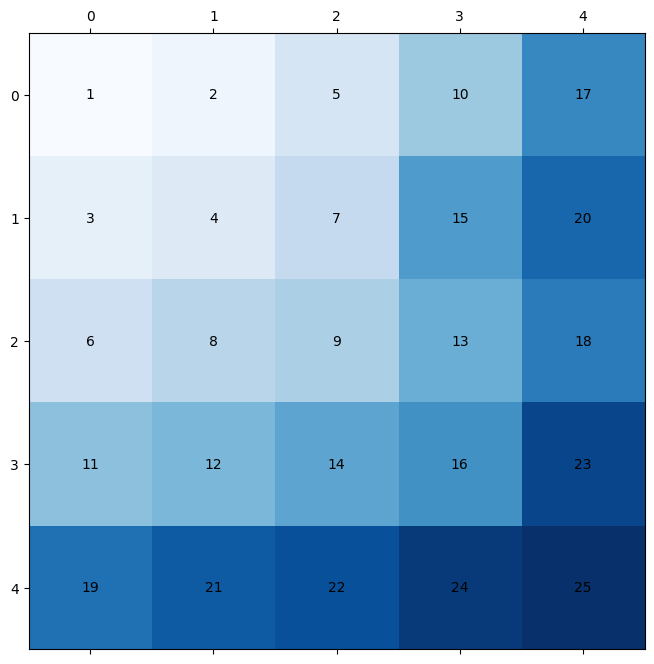

In [9]:
def plot_corner_first_ndindex(n: int, ndim: int = 2):
    """
    Plot a figure that shows the order of each grid point in the list 
    provided by the function corner_first_ndindex.
    """
    indices = corner_first_ndindex(n, ndim)
    
    # Create a 2D grid to store the order of each index
    grid = np.zeros((n, n), dtype=int)
    
    for order, (x, y) in enumerate(indices):
        grid[x, y] = order + 1  # Adding 1 to start the order from 1 instead of 0
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot the grid
    cax = ax.matshow(grid, cmap=plt.cm.Blues)
    
    # Annotate each cell with its order
    for i in range(n):
        for j in range(n):
            c = grid[j, i]
            ax.text(i, j, str(c), va='center', ha='center')
    
    # plt.title('Order of Grid Points')
    # plt.xlabel('X-axis')
    # plt.ylabel('Y-axis')
    # plt.colorbar(cax)
    # plt.savefig("corner-first-vocab.pdf")
    plt.show()

# Example plot for n=3
plot_corner_first_ndindex(5)